In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deeptime as dt
import mdtraj as mdt
from deeptime.decomposition import TICA
import seaborn as sn
from sklearn.decomposition import PCA

In [2]:
rcParams = plt.matplotlib.rcParams
rcParams["font.size"] = 15
rcParams["font.serif"] = "Palatino"
rcParams["font.sans-serif"] = "Trebuchet MS"
rcParams["font.weight"] = "bold"
rcParams["axes.titleweight"] = "bold"
rcParams["axes.labelweight"] = "bold"

Data from https://zenodo.org/record/7657119

In [3]:
# You can convert trajectories to xtc or DCD as follows if needed. For Pymol,
# rename the files: *.netcdf -> *.nc and load them together with the *.prmtop
# !mdconvert -o MEF2D_wt_sim1.xtc -t MEF2D_wt.prmtop MEF2D_wt_sim1.netcdf

## Load trajectories

In [3]:
t1 = mdt.load('MEF2D_wt_sim1.netcdf', top='MEF2D_wt.prmtop')
t2 = mdt.load('MEF2D_wt_sim2.netcdf', top='MEF2D_wt.prmtop')
t3 = mdt.load('MEF2D_wt_sim3.netcdf', top='MEF2D_wt.prmtop')

In [4]:
print(t1.n_residues)
print(t1.n_atoms)
print(t1.n_frames)

38
588
10000


## Single trajectory test

In [5]:
cont1, pairs1 = mdt.compute_contacts(t1)
cont2, _ = mdt.compute_contacts(t2)
cont3, _ = mdt.compute_contacts(t3)

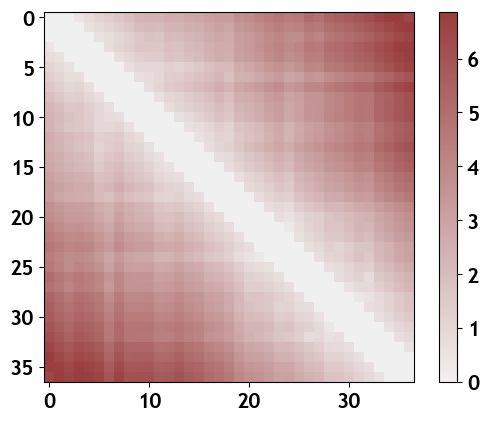

In [6]:
cmap = sn.light_palette(color=(154/256,62/256,62/256), input="rgb", as_cmap=True)

plt.imshow(mdt.geometry.squareform(cont1, pairs1)[0,:,:],cmap=cmap)
plt.colorbar()

In [17]:
tica = TICA(dim=2,lagtime=5)
model1 = tica.fit(cont1).fetch_model()
model2 = tica.fit(cont2).fetch_model()
model3 = tica.fit(cont3).fetch_model()

In [18]:
prj1 = model1.transform(cont1)
prj2 = model2.transform(cont2)
prj3 = model3.transform(cont3)

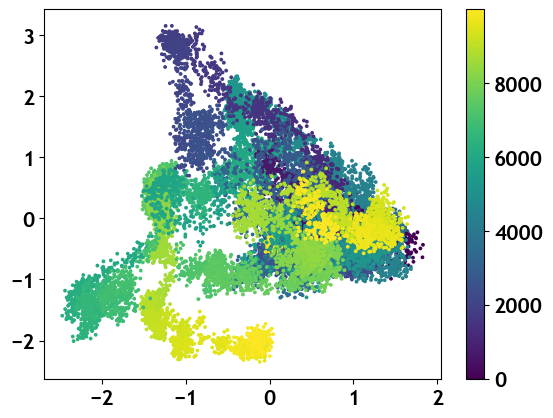

In [33]:
plt.scatter(prj1[4000:,0],prj1[4000:,1],s=3,c=range(6000))
plt.scatter(prj2[:,0],prj2[:,1],s=3,c=range(10000))
plt.scatter(prj3[:,0],prj3[:,1],s=3,c=range(10000))
plt.colorbar()

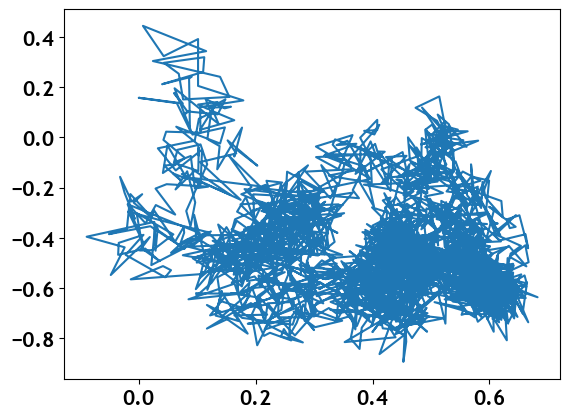

In [11]:
plt.plot(prj1[7000:,0],prj1[7000:,1])

## Concatenate trajectories and compute various featurizations

cut the first L ns

In [87]:
L1 = 1
L2 = 1
L3 = 1
lead_in1 = int(L1*1000/10)
lead_in2 = int(L2*1000/10)
lead_in3 = int(L3*1000/10)

t1c = t1[lead_in1:]
t2c = t2[lead_in2:]
t3c = t3[lead_in3:]
t123c = mdt.join([t1c,t2c,t3c])

In [88]:
t123c

<mdtraj.Trajectory with 29700 frames, 588 atoms, 38 residues, and unitcells at 0x130175430>

### Contact maps

In [72]:
cont1, _ = mdt.compute_contacts(t1c)
cont2, _ = mdt.compute_contacts(t2c)
cont3, _ = mdt.compute_contacts(t3c)

cont123, _ = mdt.compute_contacts(t123c)
# i.e.   np.vstack([cont1,cont2,cont3])

In [8]:
tica123 = TICA(dim=2, lagtime=5).fit(cont123).fetch_model()
p1=tica123.transform(cont1)
p2=tica123.transform(cont2)
p3=tica123.transform(cont3)

p123 = tica123.transform(cont123)

### Dihedral angles

In [50]:
indices = t1.topology.select("backbone and not type O")
dihed_indices = np.array([indices[i:i+4] for i in range(len(indices)-4+1)])
np.shape(dihed_indices)

(108, 4)

In [51]:
dihedrals = mdt.compute_dihedrals(t123c,dihed_indices)

dihedrals1 = mdt.compute_dihedrals(t1c,dihed_indices)
dihedrals2 = mdt.compute_dihedrals(t2c,dihed_indices)
dihedrals3 = mdt.compute_dihedrals(t3c,dihed_indices)

In [9]:
tica123 = TICA(dim=2, lagtime=5).fit(dihedrals).fetch_model()
p1=tica123.transform(dihedrals1)
p2=tica123.transform(dihedrals2)
p3=tica123.transform(dihedrals3)

p123 = tica123.transform(dihedrals)

### Dihedral angles and RMSD wrt first frame

In [89]:
indices = t1.topology.select("backbone and not type O")
dihed_indices = np.array([indices[i:i+4] for i in range(len(indices)-4+1)])
np.shape(dihed_indices)

(108, 4)

In [90]:
dihedrals = mdt.compute_dihedrals(t123c,dihed_indices)

dihedrals1 = mdt.compute_dihedrals(t1c,dihed_indices)
dihedrals2 = mdt.compute_dihedrals(t2c,dihed_indices)
dihedrals3 = mdt.compute_dihedrals(t3c,dihed_indices)

In [91]:
feat1 = np.concatenate((dihedrals1,mdt.rmsd(t1c,t1c).reshape(len(t1c),1)),axis=1)
feat2 = np.concatenate((dihedrals2,mdt.rmsd(t2c,t2c).reshape(len(t2c),1)),axis=1)
feat3 = np.concatenate((dihedrals3,mdt.rmsd(t3c,t3c).reshape(len(t3c),1)),axis=1)

In [92]:
features = np.concatenate((dihedrals,mdt.rmsd(t123c,t123c).reshape(len(t123c),1)),axis=1)

In [93]:
tica123 = TICA(dim=2, lagtime=5).fit(features).fetch_model()
p1=tica123.transform(feat1)
p2=tica123.transform(feat2)
p3=tica123.transform(feat3)

p123 = tica123.transform(features)

### Contact maps and RMSD

In [146]:
cont1, _ = mdt.compute_contacts(t1c)
cont2, _ = mdt.compute_contacts(t2c)
cont3, _ = mdt.compute_contacts(t3c)

cont123, pairs123 = mdt.compute_contacts(t123c)
# i.e.   np.vstack([cont1,cont2,cont3])

In [147]:
feat1 = np.concatenate((cont1,mdt.rmsd(t1c,t1c).reshape(len(t1c),1)),axis=1)
feat2 = np.concatenate((cont2,mdt.rmsd(t2c,t2c).reshape(len(t2c),1)),axis=1)
feat3 = np.concatenate((cont3,mdt.rmsd(t3c,t3c).reshape(len(t3c),1)),axis=1)

In [148]:
features = np.concatenate((cont123,mdt.rmsd(t123c,t123c).reshape(len(t123c),1)),axis=1)

In [149]:
tica123 = TICA(dim=2, lagtime=1).fit(features).fetch_model()
p1=tica123.transform(feat1)
p2=tica123.transform(feat2)
p3=tica123.transform(feat3)

p123 = tica123.transform(features)

In [42]:
pca123 = PCA(n_components=2).fit(features)
p1=pca123.transform(feat1)
p2=pca123.transform(feat2)
p3=pca123.transform(feat3)

p123 =pca123.transform(features)

### Plots of reduced space

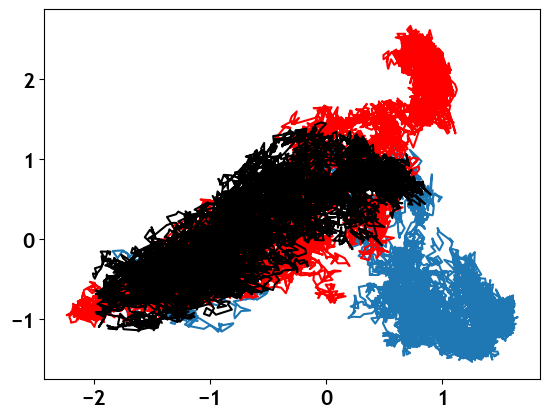

In [39]:
f, ax = plt.subplots(1)
ax.plot(p1[:,0],p1[:,1])
ax.plot(p2[:,0],p2[:,1],c="red")
ax.plot(p3[:,0],p3[:,1],c="black")


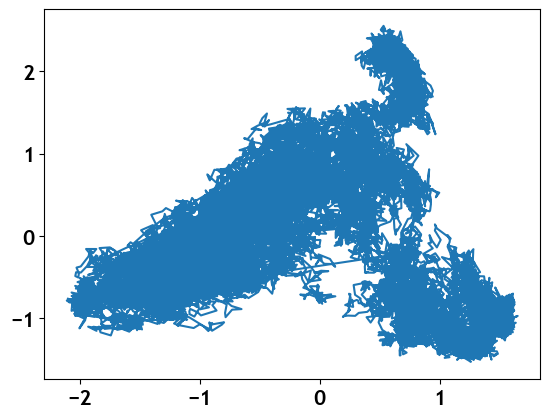

In [41]:
f, ax = plt.subplots(1)
ax.plot(p123[:,0],p123[:,1])

Text(0, 0.5, 'TICA dim 2')

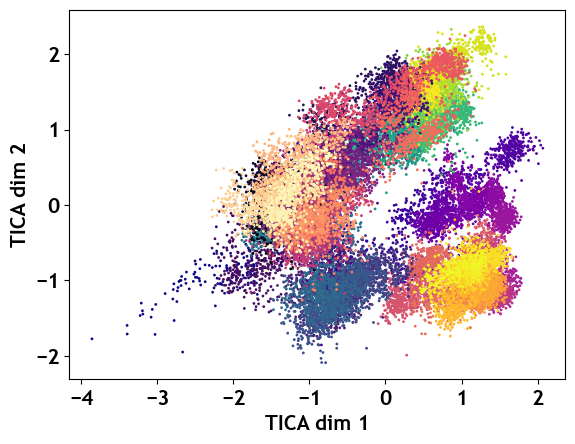

In [94]:
f, ax = plt.subplots(1)
mask1 = [i for i in range(t1c.n_frames)]
mask2 = [i for i in range(t1c.n_frames,t1c.n_frames+t2c.n_frames)]
mask3 = [i for i in range(t1c.n_frames+t2c.n_frames,t1c.n_frames+t2c.n_frames+t3c.n_frames)]
ax.scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax.scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax.scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')
# ax.set_xlim(-2.4,2)
# ax.set_ylim(-1.7,2.8)
ax.set_xlabel('TICA dim 1')
ax.set_ylabel('TICA dim 2')

## Clustering

In [95]:
K = 200
cls = dt.clustering.KMeans(n_clusters=K,init_strategy='kmeans++').fit(p123).fetch_model()
# cls = dt.clustering.RegularSpace(dmin=0.5,max_centers=K).fit(p123).fetch_model()
# cls = dt.clustering.MiniBatchKMeans(n_clusters=K,batch_size=10,init_strategy='kmeans++').fit(p123).fetch_model()
# cls = SpectralClustering(n_clusters=K).fit(p123)
# cls = DBSCAN(eps=0.1,min_samples=100).fit(p123)
dtrajs = cls.transform(p123)
# dtrajs = cls.predict(p123)
# dtrajs = cls.labels_

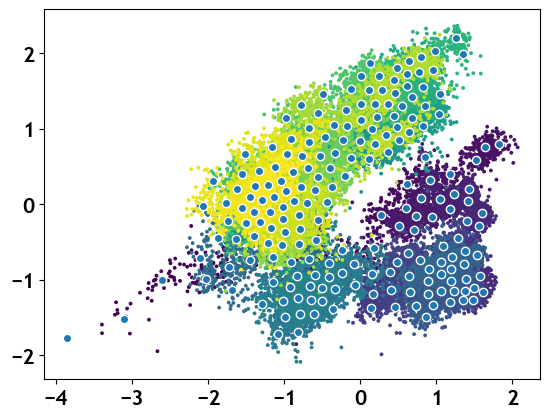

In [96]:
f, ax = plt.subplots(1)
ax.scatter(p123[:,0],p123[:,1],s=3,c=range(t123c.n_frames))
ax.scatter(*cls.cluster_centers.T,edgecolors='white')

## Markovianity condition

In [100]:
lag_times = np.arange(1, 1500, 10)
models = []

for l in lag_times:
    transition_counts = dt.markov.TransitionCountEstimator(lagtime=l, count_mode="sliding-effective").fit_fetch(dtrajs)
    models.append(dt.markov.msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(transition_counts))

its = dt.util.validation.implied_timescales(models)  

Skipping state set [125] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [125] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [125] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [140] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [125] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [140] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [44] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [125] due to error in estimation: Some row and corresponding column of the count matri

<Axes: >

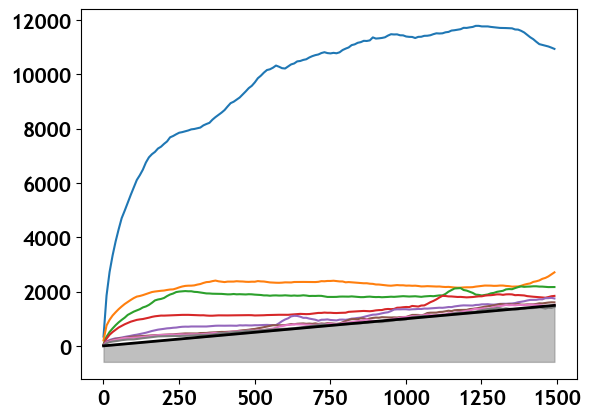

In [101]:
fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its, n_its=8, ax=ax)

### Featurization plots

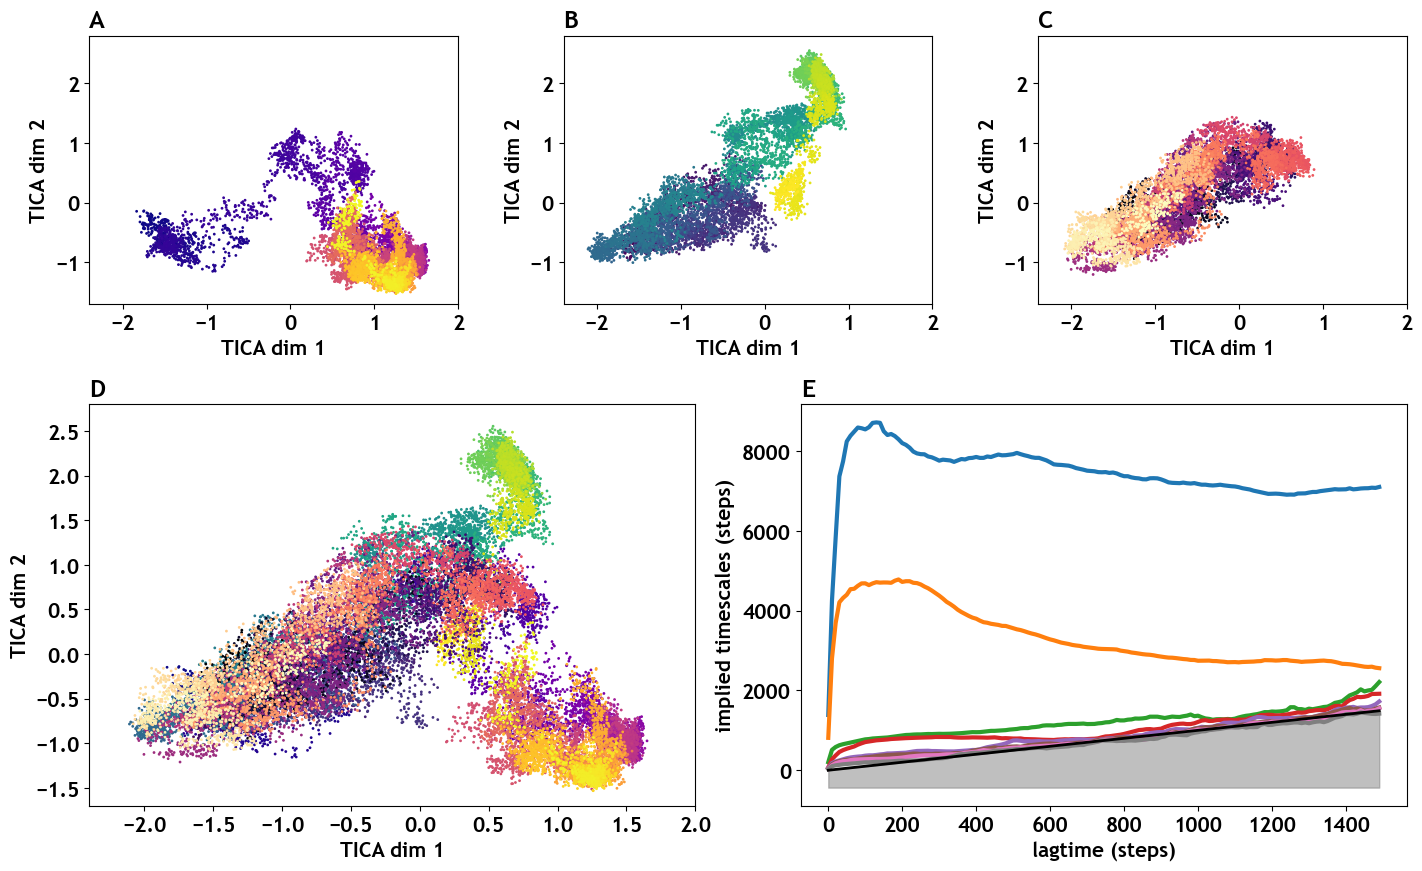

In [440]:
f = plt.figure(figsize=(17,10))
ax = f.subplot_mosaic('AABBCC;DDDEEE',gridspec_kw={"wspace":0.8,"hspace":0.3,'height_ratios':[0.4,0.6]})
ax["A"].set_title("A",loc="left")
ax["B"].set_title("B",loc="left")
ax["C"].set_title("C",loc="left")
ax["D"].set_title("D",loc="left")
ax["E"].set_title("E",loc="left")

mask1 = [i for i in range(t1c.n_frames)]
mask2 = [i for i in range(t1c.n_frames,t1c.n_frames+t2c.n_frames)]
mask3 = [i for i in range(t1c.n_frames+t2c.n_frames,t1c.n_frames+t2c.n_frames+t3c.n_frames)]

ax['A'].scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax['A'].set_xlim(-2.4,2)
ax['A'].set_ylim(-1.7,2.8)
ax['A'].set_xlabel('TICA dim 1')
ax['A'].set_ylabel('TICA dim 2')

ax['B'].scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax['B'].set_xlim(-2.4,2)
ax['B'].set_ylim(-1.7,2.8)
ax['B'].set_xlabel('TICA dim 1')
ax['B'].set_ylabel('TICA dim 2')

ax['C'].scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')
ax['C'].set_xlim(-2.4,2)
ax['C'].set_ylim(-1.7,2.8)
ax['C'].set_xlabel('TICA dim 1')
ax['C'].set_ylabel('TICA dim 2')

ax['D'].scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax['D'].scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax['D'].scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')
# ax['D'].scatter(*cls.cluster_centers.T,c='blue',edgecolors='white')
ax['D'].set_xlim(-2.4,2)
ax['D'].set_ylim(-1.7,2.8)
ax['D'].set_xlabel('TICA dim 1')
ax['D'].set_ylabel('TICA dim 2')

dt.plots.plot_implied_timescales(its, n_its=8, ax=ax['E'], linewidth=3)
ax['E'].set_xlabel('lagtime (steps)')
ax['E'].set_ylabel('implied timescales (steps)')

# plt.savefig('selection.pdf',bbox_inches='tight')

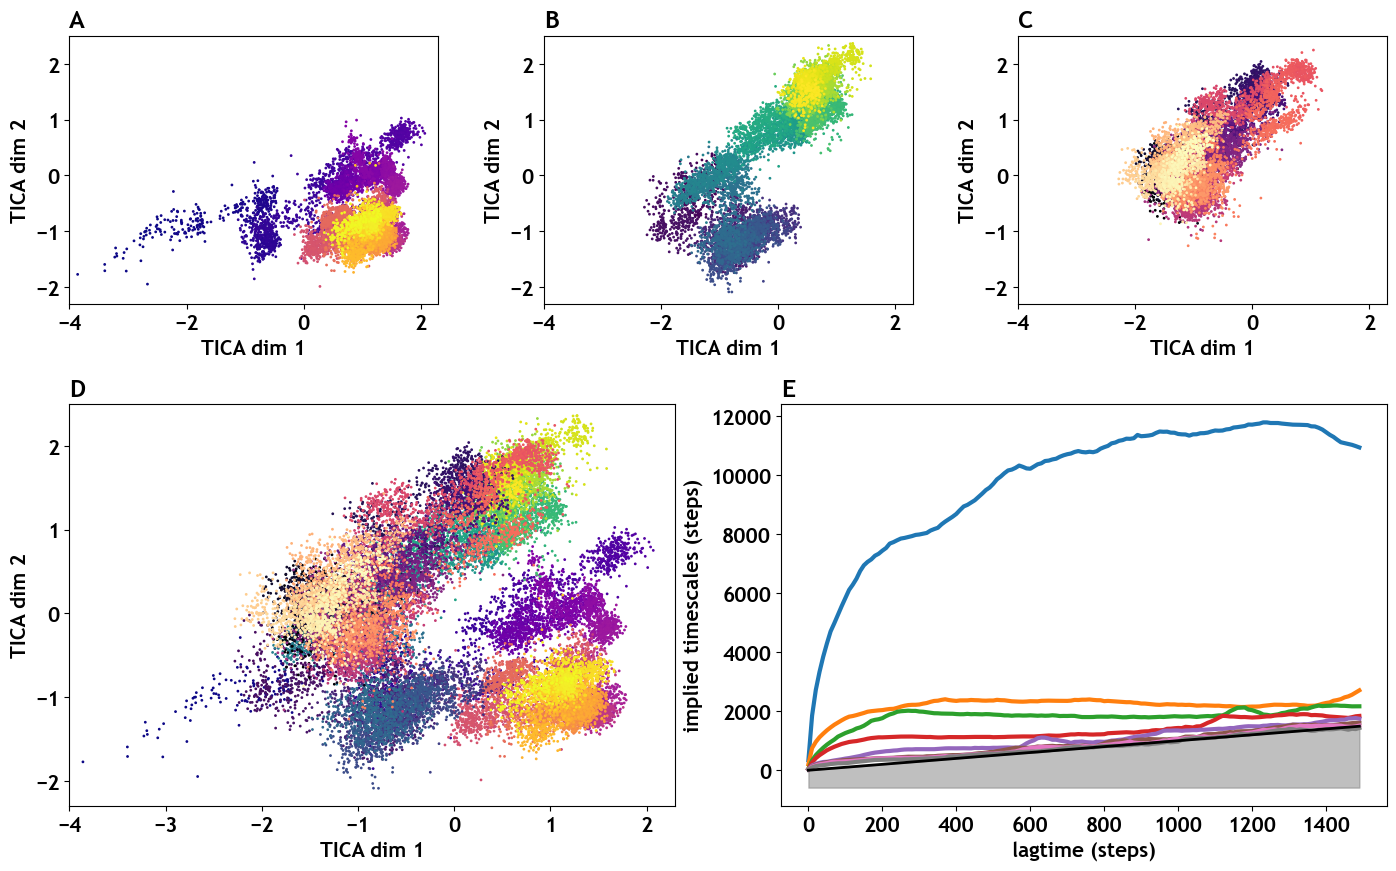

In [104]:
f = plt.figure(figsize=(17,10))
ax = f.subplot_mosaic('AABBCC;DDDEEE',gridspec_kw={"wspace":0.8,"hspace":0.3,'height_ratios':[0.4,0.6]})
ax["A"].set_title("A",loc="left")
ax["B"].set_title("B",loc="left")
ax["C"].set_title("C",loc="left")
ax["D"].set_title("D",loc="left")
ax["E"].set_title("E",loc="left")

mask1 = [i for i in range(t1c.n_frames)]
mask2 = [i for i in range(t1c.n_frames,t1c.n_frames+t2c.n_frames)]
mask3 = [i for i in range(t1c.n_frames+t2c.n_frames,t1c.n_frames+t2c.n_frames+t3c.n_frames)]

ax['A'].scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax['A'].set_xlim(-4,2.3)
ax['A'].set_ylim(-2.3,2.5)
ax['A'].set_xlabel('TICA dim 1')
ax['A'].set_ylabel('TICA dim 2')

ax['B'].scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax['B'].set_xlim(-4,2.3)
ax['B'].set_ylim(-2.3,2.5)
ax['B'].set_xlabel('TICA dim 1')
ax['B'].set_ylabel('TICA dim 2')

ax['C'].scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')
ax['C'].set_xlim(-4,2.3)
ax['C'].set_ylim(-2.3,2.5)
ax['C'].set_xlabel('TICA dim 1')
ax['C'].set_ylabel('TICA dim 2')

ax['D'].scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax['D'].scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax['D'].scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')
# ax['D'].scatter(*cls.cluster_centers.T,c='blue',edgecolors='white')
ax['D'].set_xlim(-4,2.3)
ax['D'].set_ylim(-2.3,2.5)
ax['D'].set_xlabel('TICA dim 1')
ax['D'].set_ylabel('TICA dim 2')

dt.plots.plot_implied_timescales(its, n_its=8, ax=ax['E'], linewidth=3)
ax['E'].set_xlabel('lagtime (steps)')
ax['E'].set_ylabel('implied timescales (steps)')

# plt.savefig('selection_d.pdf',bbox_inches='tight')

## Markov model estimation

In [14]:
transition_counts = dt.markov.TransitionCountEstimator(lagtime=800,
                                                       count_mode="sliding-effective").fit_fetch(
                                                        dtrajs
)

<BarContainer object of 200 artists>

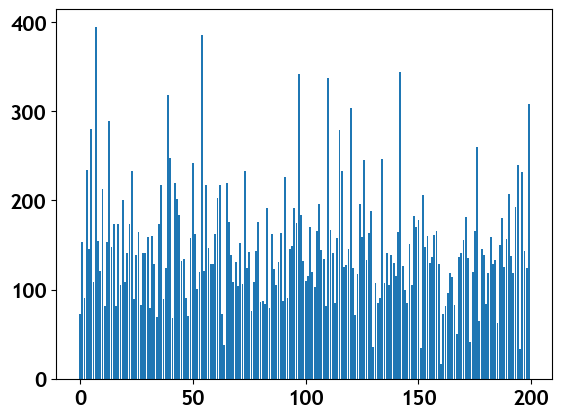

In [15]:
plt.bar(np.arange(len(transition_counts.state_histogram)),
        transition_counts.state_histogram)

In [16]:
msm_estimator = dt.markov.msm.MaximumLikelihoodMSM(reversible=True)
model = msm_estimator.fit_fetch(transition_counts)

In [17]:
model

MarkovStateModelCollection-5164986432:[{'count_models': None,
                                       'reversible': True,
                                       'stationary_distributions': None,
                                       'transition_matrices': None,
                                       'transition_matrix_tolerance': 1e-06}]

In [18]:
model.stationary_distribution

array([2.59228273e-03, 4.94374683e-03, 3.06905873e-03, 7.82712698e-03,
       5.16973860e-03, 9.64970542e-03, 3.50463733e-03, 1.34448259e-02,
       5.28484522e-03, 4.21623347e-03, 7.56789981e-03, 2.79467908e-03,
       4.95659594e-03, 9.80878630e-03, 5.18463096e-03, 6.32015132e-03,
       2.78579662e-03, 5.90190060e-03, 3.59945306e-03, 6.80893520e-03,
       3.61763302e-03, 4.77778583e-03, 6.03094697e-03, 7.36330972e-03,
       3.01982186e-03, 4.70274294e-03, 5.61476303e-03, 2.92745266e-03,
       3.48307966e-03, 5.32394588e-03, 5.57043451e-03, 1.71016081e-03,
       5.67220391e-03, 4.35967124e-03, 2.30627032e-03, 6.12546410e-03,
       7.37854190e-03, 1.86441419e-03, 4.39158311e-03, 1.07901812e-02,
       8.56990692e-03, 2.37055441e-03, 7.60341283e-03, 7.26123251e-03,
       6.34906692e-03, 4.55488658e-03, 4.61356643e-03, 2.74011252e-03,
       2.35949848e-03, 5.49031514e-03, 8.26397256e-03, 5.71794779e-03,
       3.52451533e-03, 4.25125326e-03, 1.31543211e-02, 4.13406383e-03,
      

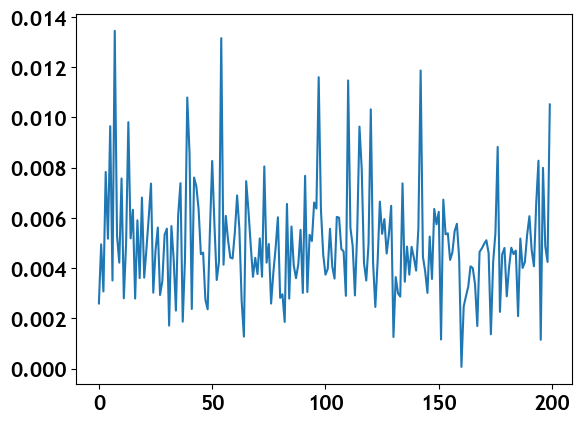

In [19]:
plt.plot(model.stationary_distribution)

In [20]:
dt.markov.compute_connected_sets(transition_counts.count_matrix)

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

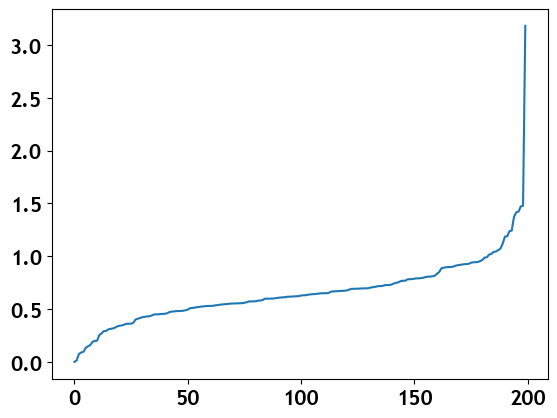

In [31]:
dG= -0.6*np.log(model.stationary_distribution)
dG=dG-np.min(dG)
plt.plot(sorted(dG))

In [38]:
low_dG_states = np.where(dG<0.3)
low_dG_states

(array([  5,   7,  13,  39,  40,  50,  54,  97, 110, 115, 120, 142, 176,
        194, 199]),)

In [42]:
low_dg_frames = np.where(np.isin(dtrajs, low_dG_states))[0]

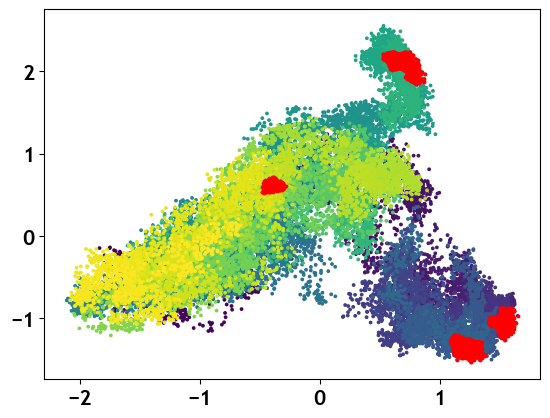

In [43]:
f, ax = plt.subplots(1)
ax.scatter(p123[:,0],p123[:,1],s=3,c=range(t123c.n_frames))
ax.scatter(p123[low_dg_frames,0],p123[low_dg_frames,1],s=3,c='red')

In [44]:
levels = np.array([0,0.1,0.2,0.3,0.5,0.7,1.0,max(dG)])
states_lev = [np.where((dG >= levels[i]) & (dG < levels[i+1]))[0] for i in range(len(levels)-1)]
frames_lev = [np.where(np.isin(dtrajs, i))[0] for i in states_lev]

/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_1289/550625417.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(p123[frames_lev[c],0],p123[frames_lev[c],1],s=3,c=current_c,label='{}-{:.2}'.format(levels[c],levels[c+1]))


Text(0, 0.5, 'TICA dim 2')

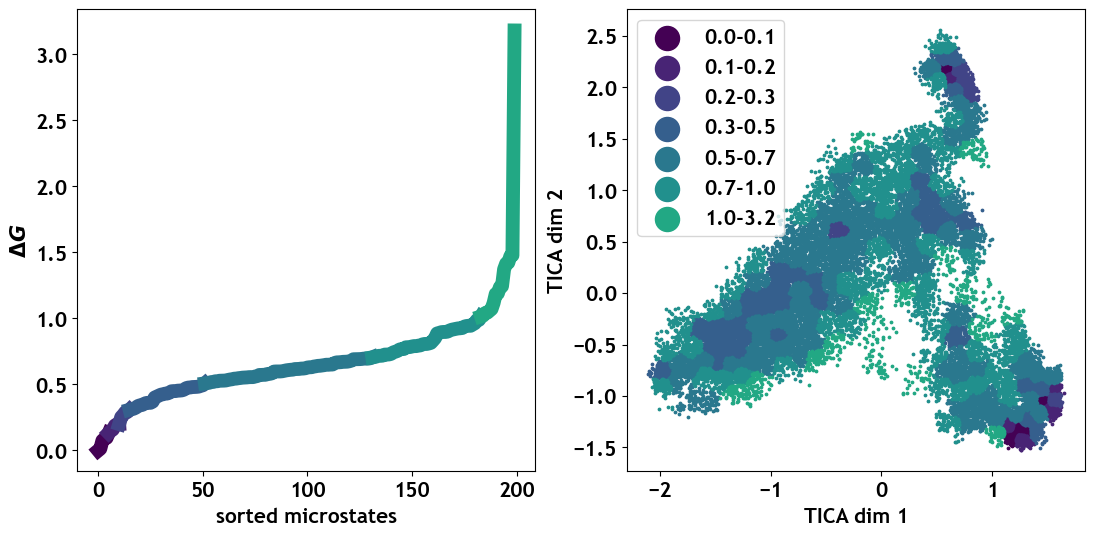

In [45]:
f, ax = plt.subplots(1,2,figsize=(13,6))

sor = np.array(sorted(dG))
xs = np.array([i for i in range(len(sor))])

temp = np.linspace(0,0.6,len(frames_lev))
col = iter(plt.cm.viridis(temp))
for c in range(len(frames_lev)):
    current_c = next(col)
    ax[1].scatter(p123[frames_lev[c],0],p123[frames_lev[c],1],s=3,c=current_c,label='{}-{:.2}'.format(levels[c],levels[c+1]))
    mask = (sor >= levels[c]) & (sor < levels[c+1])
    mask[np.argwhere(mask)[-1][0]+1] = True
    ax[0].plot(xs[mask],sor[mask],c=current_c,linewidth=10,label='{}-{:.2}'.format(levels[c],levels[c+1]))
ax[1].legend(loc='upper left',markerscale=10)
# ax[0].legend(loc='upper left',markerscale=10)
ax[0].set_xlabel('sorted microstates')
ax[0].set_ylabel(r'$\Delta G$')
ax[1].set_xlabel('TICA dim 1')
ax[1].set_ylabel('TICA dim 2')

# plt.savefig('energy_land.pdf',bbox_inches='tight')

### Implied timescales and Markovianity test

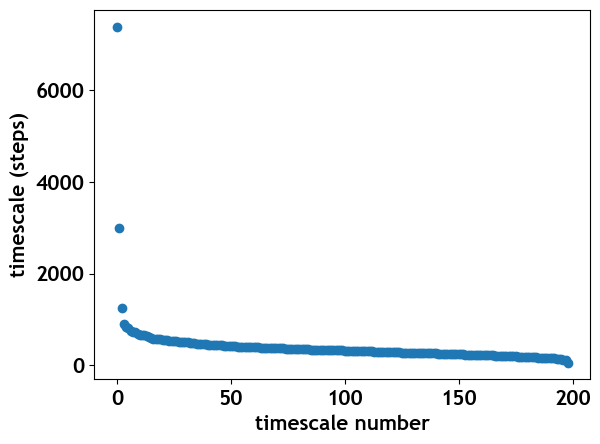

In [454]:
plt.scatter(range(len(model.timescales())),model.timescales())
plt.xlabel('timescale number')
plt.ylabel('timescale (steps)')
# plt.yscale('log')
# plt.savefig('times.pdf',bbox_inches='tight')

/Users/tommaso/Documents/Materiale UNI/V anno/Molecular Simulations/project/markovmd/lib/python3.9/site-packages/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


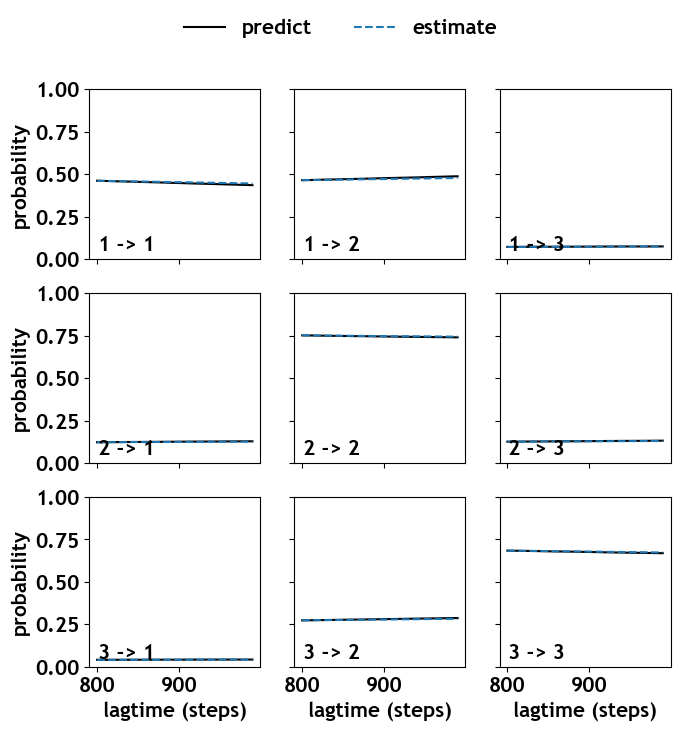

In [455]:
lag_times = np.arange(800, 1000, 10)
models = []

for l in lag_times:
    transition_counts = dt.markov.TransitionCountEstimator(lagtime=l, count_mode="sliding-effective").fit_fetch(dtrajs)
    models.append(dt.markov.msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(transition_counts))

model.ck_test(models,3,include_lag0=False).plot()
# plt.savefig('ck.pdf',bbox_inches='tight')

### PCCA and metastable states

In [22]:
n_met_set = 3

In [23]:
coarse = model.pcca(n_metastable_sets=n_met_set)

In [24]:
coarse.coarse_grained_transition_matrix

array([[0.81829895, 0.17560191, 0.00609913],
       [0.04487787, 0.92107119, 0.03405094],
       [0.00378552, 0.07419915, 0.92201532]])

In [25]:
coarse.memberships.shape

(200, 3)

In [26]:
coarse.coarse_grained_stationary_probability

array([0.14972112, 0.58370324, 0.26657564])

In [434]:
mean_t = np.zeros((n_met_set,n_met_set))
for i in range(n_met_set):
    for j in range(n_met_set):
        mean_t[i,j] = model.mfpt(coarse.sets[i],coarse.sets[j])

mean_t

array([[    0.        ,  3376.96917273, 26793.89265625],
       [28711.62095442,     0.        , 23091.9700398 ],
       [38755.24236908,  9362.2625453 ,     0.        ]])

In [468]:
[mean_t[i,:].sum() for i in range(n_met_set)]

[30170.861828976565, 51803.59099421907, 48117.504914379635]

In [66]:
met_states = [coarse.metastable_distributions[i,:].argsort()[-5:] for i in range(n_met_set)]

In [67]:
met_states

[array([ 73, 194, 115,   5, 142]),
 array([ 42,  10,   3, 116,  50]),
 array([13, 39, 54,  7, 97])]

[0.6613739892860439, 0.6959090731352529, 0.7379808593792128, 0.6360900804981551, 0.6003032849829157] [1.9767549692376842, 2.166253112863534, 2.0561049725801466, 2.086492058602589, 2.18477140376493]
[0.5348741868238615, -1.0556132635199267, -1.4792349307695696, -1.380304778729871, -0.3869439947675785] [0.7619231839290944, -0.15432924102500542, -0.3030427260644901, -0.4125358972548287, 0.6148832200642143]
[1.5465826375364025, 1.5334021865387855, 1.1729239587932707, 1.228581436195983, 1.4711649592375418] [-0.935457162403487, -1.129260846842058, -1.389432476419613, -1.3130470917320525, -1.0393382063865697]


/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_1289/2383524454.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax['A'].scatter(x1,y1,edgecolors='black',c=next(col),label='metastable set {}'.format(c))
/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_1289/2383524454.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax['B'].scatter(x1,y1,edgecolors='black',c=next(col))


Text(0, 0.5, 'TICA dim 2')

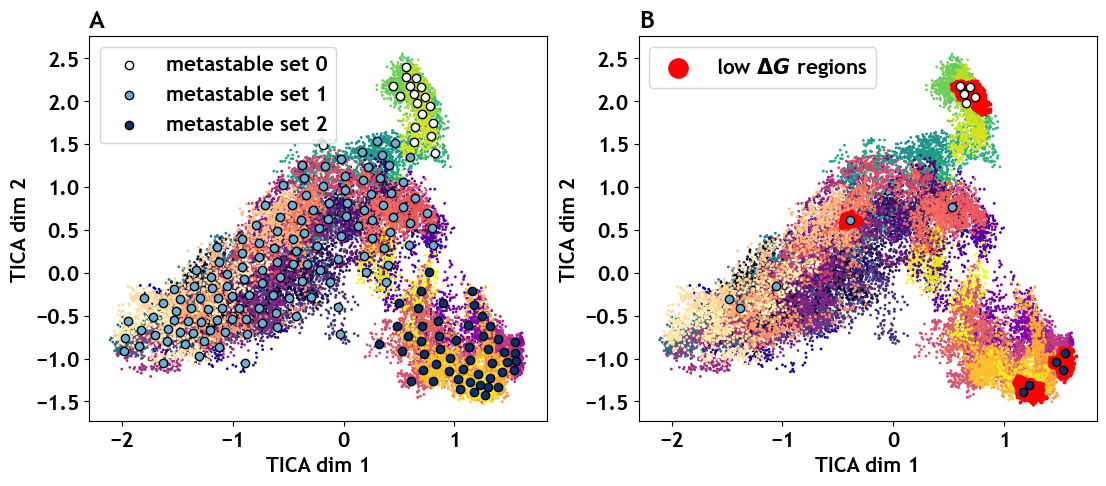

In [72]:
x1 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 0]
y1 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 0]
x2 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 1]
y2 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 1]

f = plt.figure(figsize=(13,5))
ax = f.subplot_mosaic('AB',gridspec_kw={"wspace":0.2})
ax["A"].set_title("A",loc="left")
ax["B"].set_title("B",loc="left")

mask1 = [i for i in range(t1c.n_frames)]
mask2 = [i for i in range(t1c.n_frames,t1c.n_frames+t2c.n_frames)]
mask3 = [i for i in range(t1c.n_frames+t2c.n_frames,t1c.n_frames+t2c.n_frames+t3c.n_frames)]
ax['A'].scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax['A'].scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax['A'].scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')

temp = np.linspace(0,1,n_met_set)
# np.random.shuffle(temp)
col = iter(plt.cm.Blues(temp))
for c in range(n_met_set):
    x1 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == c]
    y1 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == c]
    ax['A'].scatter(x1,y1,edgecolors='black',c=next(col),label='metastable set {}'.format(c))
ax['A'].legend()
ax['A'].set_xlabel('TICA dim 1')
ax['A'].set_ylabel('TICA dim 2')

ax['B'].scatter(p123[mask1,0],p1[mask1,1],s=1,c=range(t1c.n_frames),cmap='plasma')
ax['B'].scatter(p123[mask2,0],p123[mask2,1],s=1,c=range(t2c.n_frames),cmap='viridis')
ax['B'].scatter(p123[mask3,0],p123[mask3,1],s=1,c=range(t3c.n_frames),cmap='magma')

ax['B'].scatter(p123[low_dg_frames,0],p123[low_dg_frames,1],s=3,c='red',label=r'low $\Delta G$ regions')

temp = np.linspace(0,1,n_met_set)
# np.random.shuffle(temp)
col = iter(plt.cm.Blues(temp))
for c in range(n_met_set):
    x1 = [cls.cluster_centers[met_states[c][i],0] for i in range(5)]
    y1 = [cls.cluster_centers[met_states[c][i],1] for i in range(5)]
    print(x1,y1)
    ax['B'].scatter(x1,y1,edgecolors='black',c=next(col))
ax['B'].legend(markerscale=8)
ax['B'].set_xlabel('TICA dim 1')
ax['B'].set_ylabel('TICA dim 2')

# plt.savefig('met_sets.pdf',bbox_inches='tight')

In [73]:
selected_micro = [142,42,10,3,50,7,97] # from metastable sets 0111122

In [74]:
frames_big = [np.where(np.isin(dtrajs, selected_micro[i]))[0][0] for i in range(len(selected_micro))]

In [75]:
frames_big

[16565, 1381, 749, 71, 10621, 4628, 2708]

In [77]:
for i in frames_big:
    t123c[i].save_pdb("frames_big/{}.pdb".format(i))

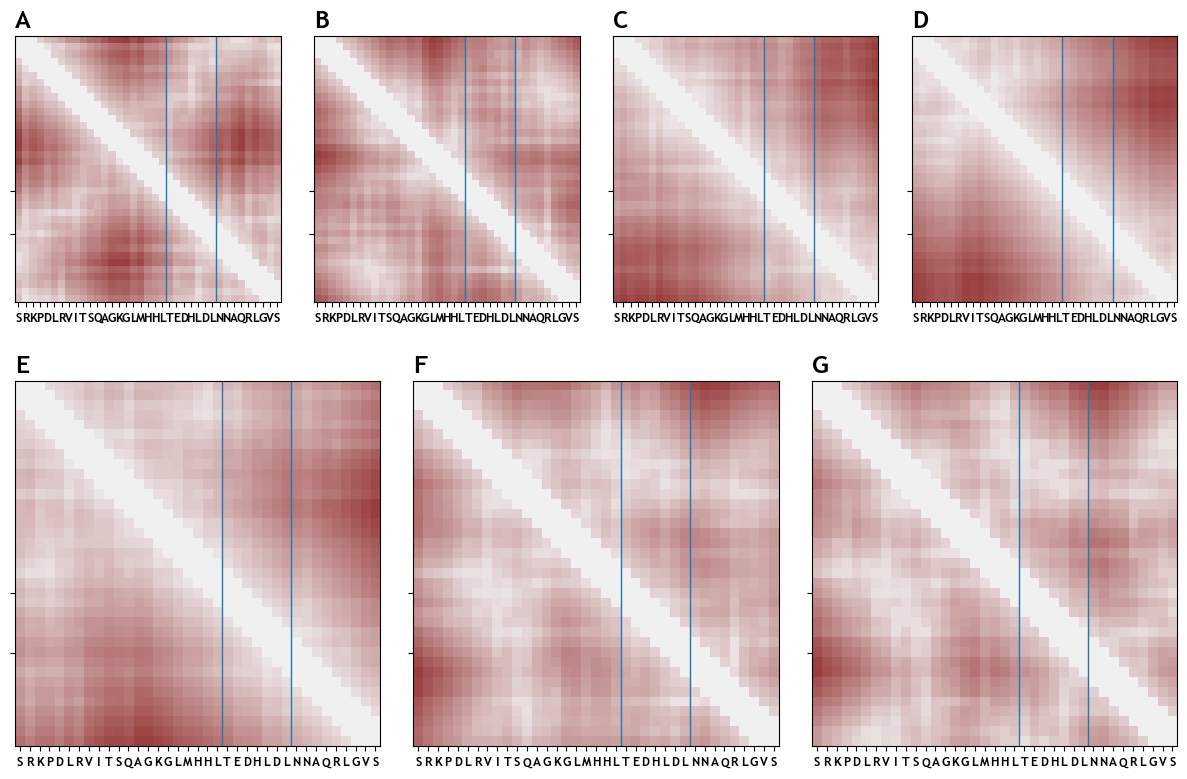

In [110]:
cmap = sn.light_palette(color=(154/256,62/256,62/256), input="rgb", as_cmap=True)

f = plt.figure(figsize=(15,10))
ax = f.subplot_mosaic('AAABBBCCCDDD;EEEEFFFFGGGG',gridspec_kw={"wspace":0.5,"hspace":0.05,'height_ratios':[0.4,0.6]},sharey=True)
fr = 0
aa = 'SRKPDLRVITSQAGKGLMHHLTEDHLDLNNAQRLGVS'
for i in 'ABCDEFG':
    ax[i].set_title(i,loc="left")
    ax[i].imshow(mdt.geometry.squareform(cont123, pairs123)[frames_big[fr],:,:],cmap=cmap)
    ax[i].set_xticks([i for i in range(37)])
    ax[i].set_xticklabels(aa,size=9)
    ax[i].set_yticks([21,27])
    ax[i].set_yticklabels([])
    ax[i].plot([20.5,20.5],[-0.5,36.5],c='tab:blue',linewidth=1)
    ax[i].plot([27.5,27.5],[-0.5,36.5],c='tab:blue',linewidth=1)
    fr += 1

# plt.savefig('contacts.pdf',bbox_inches='tight')

## Restriction to the third replicate

In [153]:
indices = t1.topology.select("backbone and not type O")
dihed_indices = np.array([indices[i:i+4] for i in range(len(indices)-4+1)])
dihedrals3 = mdt.compute_dihedrals(t3c,dihed_indices)
feat3 = np.concatenate((dihedrals3,mdt.rmsd(t3c,t3c).reshape(len(t3c),1)),axis=1)

In [154]:
feat = feat3[100:] # dihedral and rmsd
fr = t3c[100:].n_frames
tica3 = TICA(dim=2, lagtime=1).fit(feat).fetch_model()
p3=tica3.transform(feat)

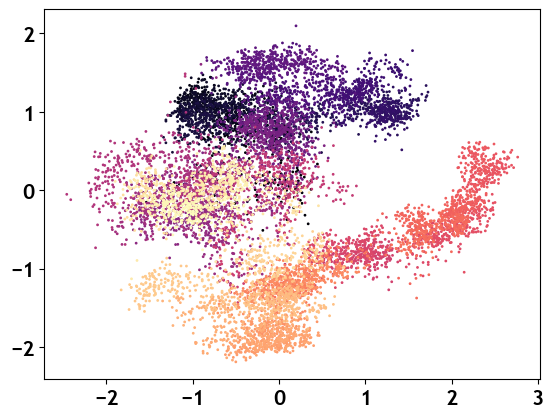

In [109]:
f, ax = plt.subplots(1)
ax.scatter(p3[:,0],p3[:,1],s=1,c=range(fr),cmap='magma')

In [110]:
K = 50
cls = dt.clustering.KMeans(n_clusters=K,init_strategy='kmeans++').fit(p3).fetch_model()
dtrajs = cls.transform(p3)

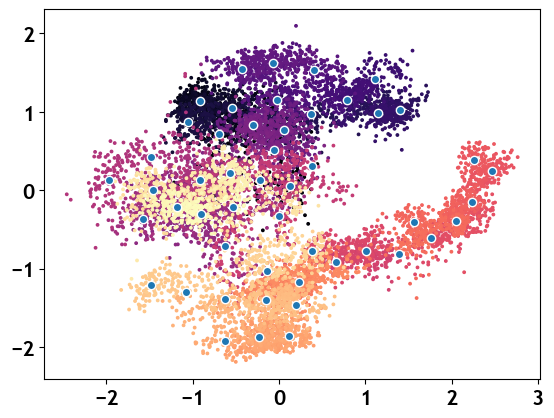

In [129]:
f, ax = plt.subplots(1)
ax.scatter(p3[:,0],p3[:,1],s=3,c=range(fr),cmap='magma')
ax.scatter(cls.cluster_centers.T[0,:],cls.cluster_centers.T[1,:],c='tab:blue',edgecolors='white')

In [112]:
lag_times = np.arange(1, 500, 10)
models = []

for l in lag_times:
    transition_counts = dt.markov.TransitionCountEstimator(lagtime=l, count_mode="sliding-effective").fit_fetch(dtrajs)
    models.append(dt.markov.msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(transition_counts))

its = dt.util.validation.implied_timescales(models)  

<Axes: >

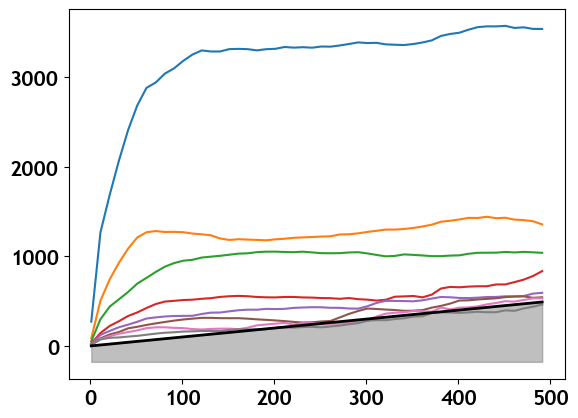

In [113]:
fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its, n_its=8, ax=ax)

In [114]:
transition_counts = dt.markov.TransitionCountEstimator(lagtime=200,
                                                       count_mode="sliding-effective").fit_fetch(
                                                        dtrajs
)

<BarContainer object of 50 artists>

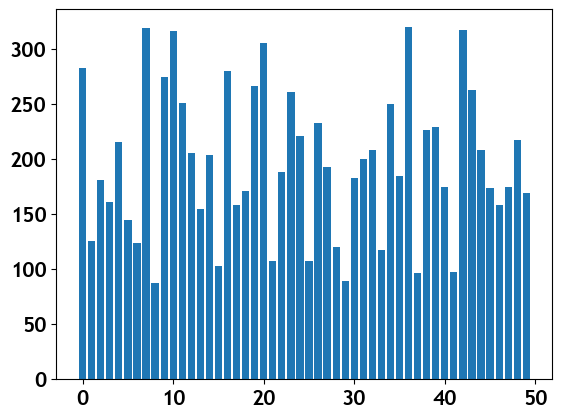

In [115]:
plt.bar(np.arange(len(transition_counts.state_histogram)),
        transition_counts.state_histogram)

In [116]:
msm_estimator = dt.markov.msm.MaximumLikelihoodMSM(reversible=True)
model = msm_estimator.fit_fetch(transition_counts)

In [117]:
model

MarkovStateModelCollection-5100175952:[{'count_models': None,
                                       'reversible': True,
                                       'stationary_distributions': None,
                                       'transition_matrices': None,
                                       'transition_matrix_tolerance': 1e-06}]

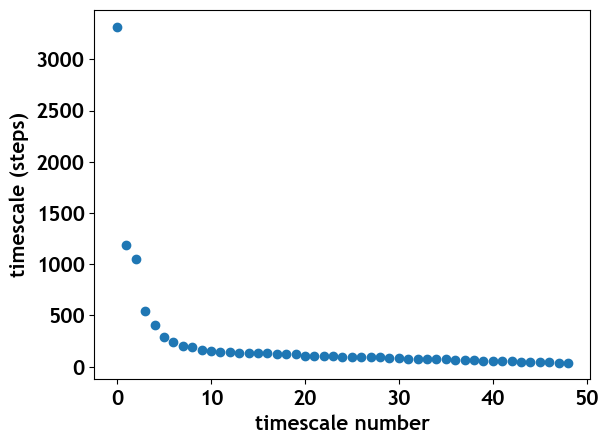

In [131]:
plt.scatter(range(len(model.timescales())),model.timescales())
plt.xlabel('timescale number')
plt.ylabel('timescale (steps)')

# plt.savefig('times_3.pdf',bbox_inches='tight')

/Users/tommaso/Documents/Materiale UNI/V anno/Molecular Simulations/project/markovmd/lib/python3.9/site-packages/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


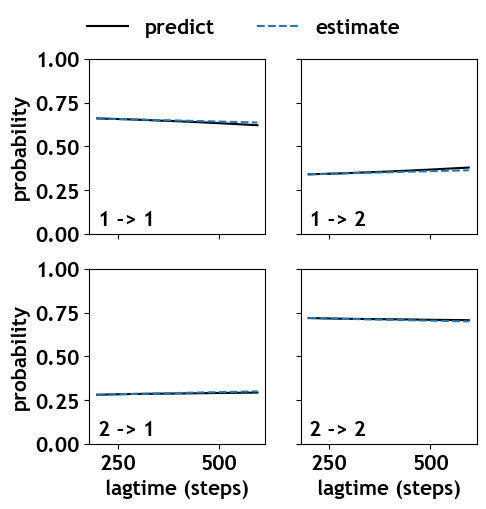

In [132]:
lag_times = np.arange(200, 600, 5)
models = []

for l in lag_times:
    transition_counts = dt.markov.TransitionCountEstimator(lagtime=l, count_mode="sliding-effective").fit_fetch(dtrajs)
    models.append(dt.markov.msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(transition_counts))

model.ck_test(models,2,include_lag0=False,err_est=True).plot()

# plt.savefig('ck_3.pdf',bbox_inches='tight')

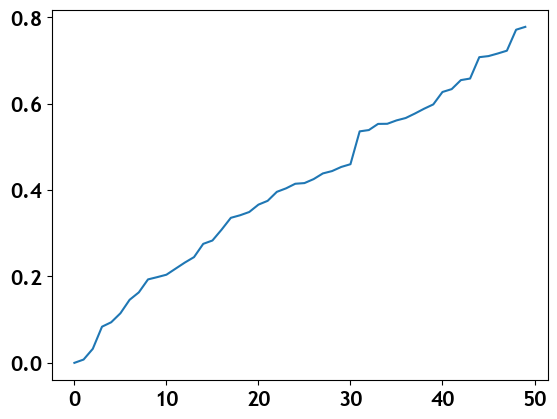

In [133]:
dG= -0.6*np.log(model.stationary_distribution)
dG=dG-np.min(dG)
plt.plot(sorted(dG))

In [134]:
low_dG_states = np.where(dG<0.2)
low_dG_states

(array([ 0,  7,  9, 10, 11, 19, 20, 26, 34, 36]),)

In [136]:
low_dg_frames = np.where(np.isin(dtrajs, low_dG_states))[0]

In [120]:
n_met_set = 2

In [121]:
coarse = model.pcca(n_metastable_sets=n_met_set)

In [122]:
coarse.coarse_grained_stationary_probability

array([0.45220919, 0.54779081])

In [123]:
coarse.coarse_grained_transition_matrix

array([[0.96795977, 0.03204023],
       [0.02644967, 0.97355033]])

In [193]:
coarse.memberships.shape

(50, 2)

In [125]:
assignments = coarse.assignments

In [127]:
mean_t = np.zeros((n_met_set,n_met_set))
for i in range(n_met_set):
    for j in range(n_met_set):
        mean_t[i,j] = model.mfpt(coarse.sets[i],coarse.sets[j])

mean_t

array([[   0.        , 3193.51997964],
       [4016.77064092,    0.        ]])

In [128]:
[mean_t[i,:].sum() for i in range(n_met_set)]

[3193.519979643934, 4016.7706409165157]

In [139]:
met_states = [coarse.metastable_distributions[i,:].argsort()[-5:] for i in range(n_met_set)]

In [140]:
met_states

[array([20, 42, 10, 23,  7]), array([26, 11,  9, 19, 36])]

[-0.9075183979702589, -0.2951869785232202, -0.9191890202833444, 0.7902641814981496, -0.9150826500803102] [-0.3055150216877139, 0.8305484522056379, 0.1349565049999977, 1.1543667647709537, 1.1404382486655111]
[0.11557846761199721, -0.2321985047554725, -0.14750060807310209, 2.050083274350458, 0.22900037854573152] [-1.8665746376937407, -1.8727539342782684, -1.4015990565817131, -0.39745863242736634, -1.1733642050016557]


/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_6204/3880278405.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax['A'].scatter(x1,y1,edgecolors='black',c=next(col),label='metastable set {}'.format(c))
/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_6204/3880278405.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax['B'].scatter(x1,y1,edgecolors='black',c=next(col))


Text(0, 0.5, 'TICA dim 2')

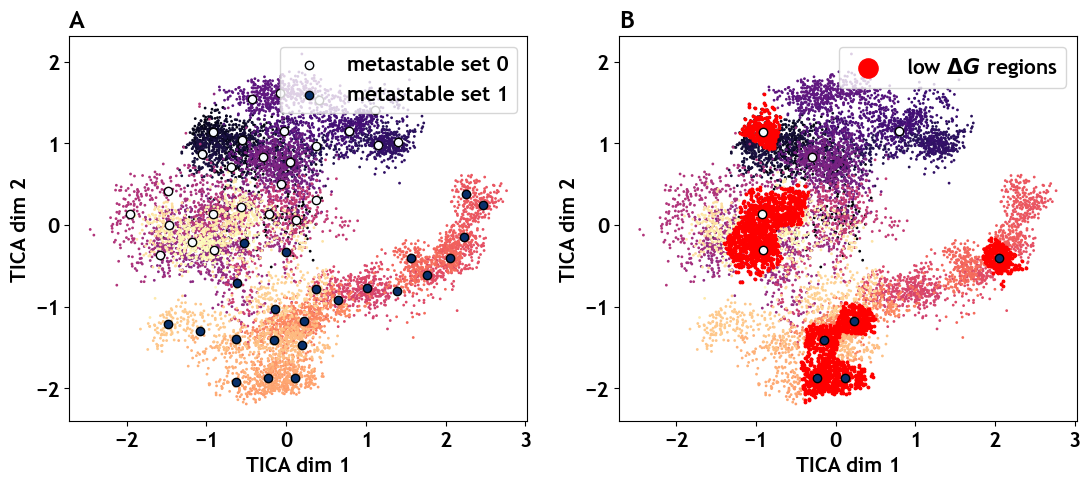

In [141]:
x1 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 0]
y1 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 0]
x2 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 1]
y2 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 1]

f = plt.figure(figsize=(13,5))
ax = f.subplot_mosaic('AB',gridspec_kw={"wspace":0.2})
ax["A"].set_title("A",loc="left")
ax["B"].set_title("B",loc="left")

ax['A'].scatter(p3[:,0],p3[:,1],s=1,c=range(fr),cmap='magma')

temp = np.linspace(0,1,n_met_set)
# np.random.shuffle(temp)
col = iter(plt.cm.Blues(temp))
for c in range(n_met_set):
    x1 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == c]
    y1 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == c]
    ax['A'].scatter(x1,y1,edgecolors='black',c=next(col),label='metastable set {}'.format(c))
ax['A'].legend()
ax['A'].set_xlabel('TICA dim 1')
ax['A'].set_ylabel('TICA dim 2')

ax['B'].scatter(p3[:,0],p3[:,1],s=1,c=range(fr),cmap='magma')

ax['B'].scatter(p3[low_dg_frames,0],p3[low_dg_frames,1],s=3,c='red',label=r'low $\Delta G$ regions')

temp = np.linspace(0,1,n_met_set)
# np.random.shuffle(temp)
col = iter(plt.cm.Blues(temp))
for c in range(n_met_set):
    x1 = [cls.cluster_centers[met_states[c][i],0] for i in range(5)]
    y1 = [cls.cluster_centers[met_states[c][i],1] for i in range(5)]
    print(x1,y1)
    ax['B'].scatter(x1,y1,edgecolors='black',c=next(col))
ax['B'].legend(markerscale=8)
ax['B'].set_xlabel('TICA dim 1')
ax['B'].set_ylabel('TICA dim 2')

# plt.savefig('met_sets.pdf',bbox_inches='tight')

In [142]:
micro_states = [np.where(np.isin(dtrajs, coarse.sets[i]))[0] for i in range(n_met_set)]

In [143]:
micro_states

[array([   0,    1,    2, ..., 9773, 9774, 9775]),
 array([   9,   10,   12, ..., 9797, 9798, 9799])]

### Map back

In [144]:
micro_states = [i + 100 + len(t1c) + len(t2c) for i in micro_states]

/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_6204/4292696581.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax['A'].scatter(x1,y1,edgecolors='black',c=next(col),label='metastable set {}'.format(c))
/var/folders/xg/kk8p9yj50tb0f4np6fj1pz6h0000gn/T/ipykernel_6204/4292696581.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax['B'].scatter(x1,y1,edgecolors='black',c=next(col))


[-0.9075183979702589, -0.2951869785232202, -0.9191890202833444, 0.7902641814981496, -0.9150826500803102] [-0.3055150216877139, 0.8305484522056379, 0.1349565049999977, 1.1543667647709537, 1.1404382486655111]
[0.11557846761199721, -0.2321985047554725, -0.14750060807310209, 2.050083274350458, 0.22900037854573152] [-1.8665746376937407, -1.8727539342782684, -1.4015990565817131, -0.39745863242736634, -1.1733642050016557]


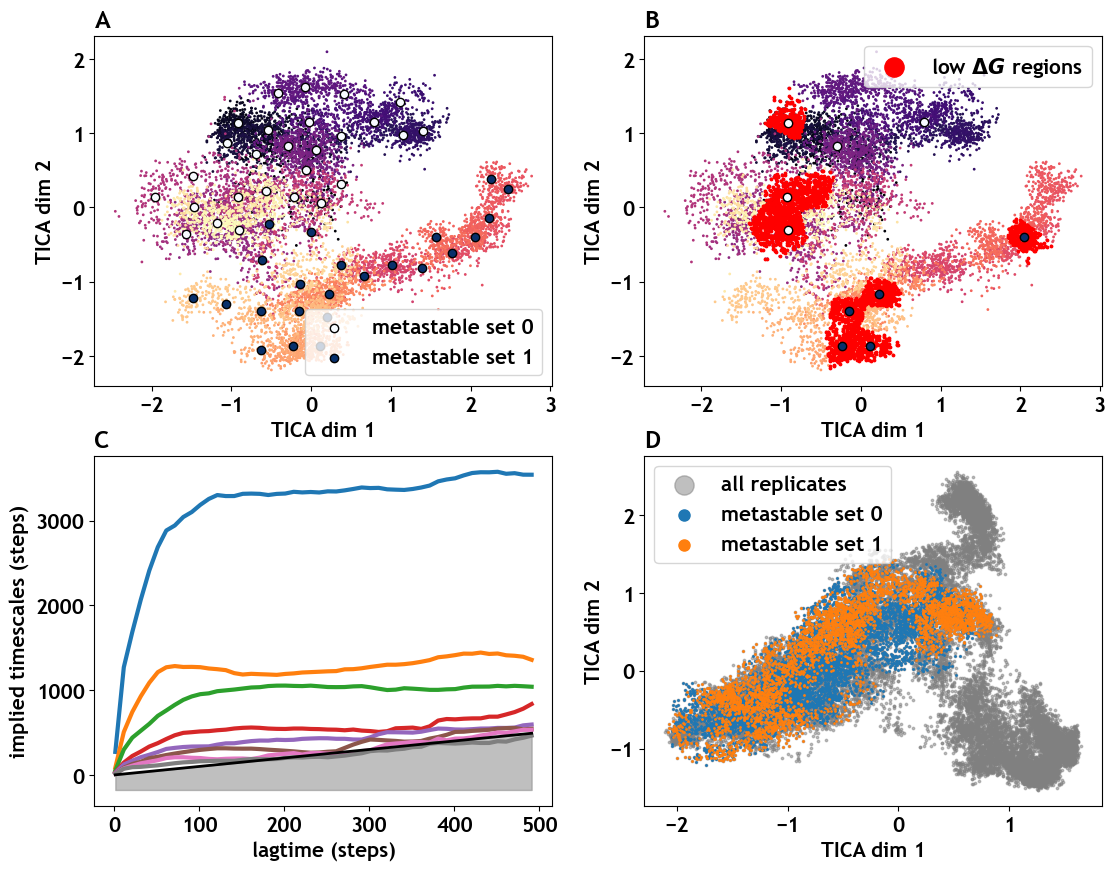

In [157]:
x1 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 0]
y1 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 0]
x2 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 1]
y2 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == 1]

f = plt.figure(figsize=(13,10))
ax = f.subplot_mosaic('AB;CD',gridspec_kw={"wspace":0.2})
ax["A"].set_title("A",loc="left")
ax["B"].set_title("B",loc="left")
ax["C"].set_title("C",loc="left")
ax["D"].set_title("D",loc="left")

ax['A'].scatter(p3[:,0],p3[:,1],s=1,c=range(fr),cmap='magma')

temp = np.linspace(0,1,n_met_set)
# np.random.shuffle(temp)
col = iter(plt.cm.Blues(temp))
for c in range(n_met_set):
    x1 = [cls.cluster_centers[i,0] for i in range(len(coarse.assignments)) if coarse.assignments[i] == c]
    y1 = [cls.cluster_centers[i,1] for i in range(len(coarse.assignments)) if coarse.assignments[i] == c]
    ax['A'].scatter(x1,y1,edgecolors='black',c=next(col),label='metastable set {}'.format(c))
ax['A'].legend()
ax['A'].set_xlabel('TICA dim 1')
ax['A'].set_ylabel('TICA dim 2')

ax['B'].scatter(p3[:,0],p3[:,1],s=1,c=range(fr),cmap='magma')

ax['B'].scatter(p3[low_dg_frames,0],p3[low_dg_frames,1],s=3,c='red',label=r'low $\Delta G$ regions')

temp = np.linspace(0,1,n_met_set)
# np.random.shuffle(temp)
col = iter(plt.cm.Blues(temp))
for c in range(n_met_set):
    x1 = [cls.cluster_centers[met_states[c][i],0] for i in range(5)]
    y1 = [cls.cluster_centers[met_states[c][i],1] for i in range(5)]
    print(x1,y1)
    ax['B'].scatter(x1,y1,edgecolors='black',c=next(col))
ax['B'].legend(markerscale=8)
ax['B'].set_xlabel('TICA dim 1')
ax['B'].set_ylabel('TICA dim 2')

dt.plots.plot_implied_timescales(its, n_its=8, ax=ax['C'], linewidth=3)
ax['C'].set_xlabel('lagtime (steps)')
ax['C'].set_ylabel('implied timescales (steps)')


ax['D'].scatter(p123[:,0],p123[:,1],s=3,c='gray',alpha=0.5,label='all replicates')
ax['D'].scatter(p123[micro_states[0],0],p123[micro_states[0],1],s=1,c='tab:blue',label='metastable set 0')
ax['D'].scatter(p123[micro_states[1],0],p123[micro_states[1],1],s=1,c='tab:orange',label='metastable set 1')
ax['D'].legend(markerscale=8)
ax['D'].set_xlabel('TICA dim 1')
ax['D'].set_ylabel('TICA dim 2')

# plt.savefig('only3.pdf',bbox_inches='tight')